<a href="https://colab.research.google.com/github/AUT-Student/BigData-HW2/blob/main/BigData_HW2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: ‌Big Data
<br>
<b>Description:</b> HomeWork 1 | Question 3
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# PySpark Setting

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql import Window

# Dataset

In [ ]:
!gdown 1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
!unzip /content/Bigdata_hw2_datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
To: /content/Bigdata_hw2_datasets.zip
100% 6.28M/6.28M [00:00<00:00, 167MB/s]
Archive:  /content/Bigdata_hw2_datasets.zip
replace Bigdata_hw2_datasets/q1/stream_data_dgim.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Bigdata_hw2_datasets/q1/stream_data_dgim.txt  
  inflating: Bigdata_hw2_datasets/q2/games.csv  
  inflating: Bigdata_hw2_datasets/q2/ratings.csv  
  inflating: Bigdata_hw2_datasets/q3/c1.txt  
  inflating: Bigdata_hw2_datasets/q3/c2.txt  
  inflating: Bigdata_hw2_datasets/q3/data.txt  


In [ ]:
dataset_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/data.txt", header=None, names=["data"])
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda x:x.split(" "))
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda item: [float(x) for x in item])
dataset_pandas["data-id"] = range(len(dataset_pandas))

c1_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c1.txt", header=None, names=["center"])
c1_pandas["center"] = c1_pandas["center"].apply(lambda x:x.split(" "))
c1_pandas["center"] = c1_pandas["center"].apply(lambda item: [float(x) for x in item])
c1_pandas["center-id"] = range(len(c1_pandas))

c2_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c2.txt", header=None, names=["center"])
c2_pandas["center"] = c2_pandas["center"].apply(lambda x:x.split(" "))
c2_pandas["center"] = c2_pandas["center"].apply(lambda item: [float(x) for x in item])
c2_pandas["center-id"] = range(len(c2_pandas))

In [ ]:
NUMBER_FEATURES = len(dataset_pandas["data"].values[0])

# KMeans

In [ ]:
class SparkKMeans():
  def __init__(self, dataset, center, description, distance_metric_name):
    self.dataset_spark = spark.createDataFrame(dataset)
    self.center_spark = spark.createDataFrame(center)
    self.description = description

    if distance_metric_name == "Euclidean":
      self.distance_metric = self.euclidean_distance
    elif distance_metric_name == "Manhatan":
      self.distance_metric = self.manhatan_distance
    else:
      raise Exception("Invalid distance_metric_name!")

  def run(self, number_steps):
    self.number_steps = number_steps
    self.costs = []
    for step in range(number_steps):
      data_center_spark = self.dataset_spark.join(self.center_spark)\
                              .withColumn('distance', self.distance_metric(self.dataset_spark.data, self.center_spark.center))

      data_center_spark = data_center_spark.withColumn("min-distance", f.min("distance")\
                                           .over(Window.partitionBy("data-id")))\
                                           .where(f.col("min-distance") == f.col("distance"))\
                                           .drop(*["min-distance", "center"])


      step_cost = data_center_spark.withColumn("sum-distance", f.col("distance")**2)\
                                   .select("sum-distance")\
                                   .groupBy().sum().collect()[0][0]

      self.costs.append(step_cost)
      print(f"Step = {step}, Cost = {step_cost}")

      data_center_mapping = data_center_spark.drop(*["data", "distance"])\
                                             .toDF("data-id", "center-id")\
                                             .toPandas()
      
      data_center_spark = data_center_spark.groupBy("center-id")\
                                           .agg(f.collect_list("data")\
                                           .alias("data-list"))

      array_mean_udf = udf(self.array_mean, ArrayType(FloatType()))

      self.center_spark = data_center_spark.select("center-id", array_mean_udf("data-list")\
                                           .alias("center"))

    return data_center_mapping

  def report(self):
    print(f"Change cost percent in ten steps {int((self.costs[0] - self.costs[10]) / self.costs[0] * 100)}%\n") 

    plt.scatter(range(1, self.number_steps+1), self.costs, color="green")
    plt.plot(range(1, self.number_steps+1), self.costs, color="green")
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.title(f"Change Cost in KMeans\n{self.description}")
    plt.show()

  @staticmethod
  def euclidean_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += (a[i] - b[i]) ** 2
    return distance ** 0.5

  @staticmethod
  def manhatan_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += f.abs(a[i] - b[i])
    return distance

  @staticmethod
  def array_mean(x):
    number_data = len([i for i in zip(*x)][0])
    sum_array = [sum(i) for i in zip(*x)]
    return [item/number_data for item in sum_array]

# Results

Distance Metric = Euclidean | Center Name = C1
Step = 0, Cost = 623660345.3064235
Step = 1, Cost = 509862910.53849345
Step = 2, Cost = 485480688.18347406
Step = 3, Cost = 463997009.2097292
Step = 4, Cost = 460969266.6840041
Step = 5, Cost = 460537848.1230785
Step = 6, Cost = 460313099.4867738
Step = 7, Cost = 460003523.95227706
Step = 8, Cost = 459570539.7357615
Step = 9, Cost = 459021103.3156657
Step = 10, Cost = 458490656.0775711
Step = 11, Cost = 457944232.48794186
Step = 12, Cost = 457558005.1940546
Step = 13, Cost = 457290136.3899215
Step = 14, Cost = 457050555.12510836
Step = 15, Cost = 456892235.4659206
Step = 16, Cost = 456703630.8449933
Step = 17, Cost = 456404203.00578594
Step = 18, Cost = 456177800.23673755
Step = 19, Cost = 455986870.9150199
Change cost percent in ten steps 26%



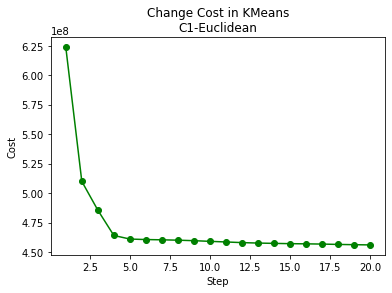

Distance Metric = Euclidean | Center Name = C2
Step = 0, Cost = 438747790.027918
Step = 1, Cost = 249803935.70161507
Step = 2, Cost = 194494813.96287614
Step = 3, Cost = 169804841.97719902
Step = 4, Cost = 156295749.78985724
Step = 5, Cost = 149094208.90567484
Step = 6, Cost = 142508532.1527767
Step = 7, Cost = 132303870.55302179
Step = 8, Cost = 117170969.95643498
Step = 9, Cost = 108547375.61222848
Step = 10, Cost = 102237204.4029776
Step = 11, Cost = 98278015.30444138
Step = 12, Cost = 95630225.77633072
Step = 13, Cost = 93793312.9526939
Step = 14, Cost = 92377131.22786814
Step = 15, Cost = 91541606.9722778
Step = 16, Cost = 91045574.40593557
Step = 17, Cost = 90752240.01219653
Step = 18, Cost = 90470170.14143302
Step = 19, Cost = 90216416.1874635
Change cost percent in ten steps 76%



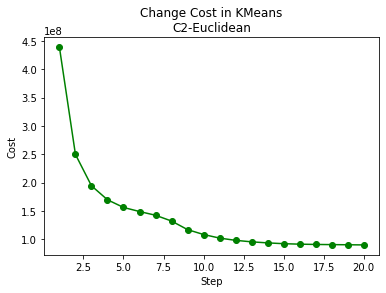

Distance Metric = Manhatan | Center Name = C1
Step = 0, Cost = 913011909.908313
Step = 1, Cost = 742983055.6934764
Step = 2, Cost = 710487804.6999178
Step = 3, Cost = 691517780.6043844
Step = 4, Cost = 684105503.573466
Step = 5, Cost = 679402404.7557327
Step = 6, Cost = 674644839.6651711
Step = 7, Cost = 661742282.1865252
Step = 8, Cost = 638233760.1071458
Step = 9, Cost = 534830360.37700003
Step = 10, Cost = 349867309.16741186
Step = 11, Cost = 321153592.52010876
Step = 12, Cost = 318674207.1774839
Step = 13, Cost = 316439497.20484793
Step = 14, Cost = 313858405.8929927
Step = 15, Cost = 312009200.9003784
Step = 16, Cost = 310765764.71265453
Step = 17, Cost = 308057162.1968339
Step = 18, Cost = 305352253.5955057
Step = 19, Cost = 303165893.16335285
Change cost percent in ten steps 61%



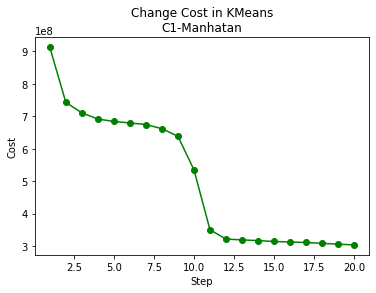

Distance Metric = Manhatan | Center Name = C2
Step = 0, Cost = 655439563.7534105
Step = 1, Cost = 425797397.025825
Step = 2, Cost = 340841789.26993954
Step = 3, Cost = 300225434.7591959
Step = 4, Cost = 288288120.48631114
Step = 5, Cost = 280744104.315305
Step = 6, Cost = 263746381.151768
Step = 7, Cost = 245483159.6616205
Step = 8, Cost = 210918225.84448966
Step = 9, Cost = 194368603.97587886
Step = 10, Cost = 187496283.23279405
Step = 11, Cost = 185418200.26393723
Step = 12, Cost = 183521868.13487425
Step = 13, Cost = 182150585.215305
Step = 14, Cost = 181485856.73020256
Step = 15, Cost = 180706293.80019116
Step = 16, Cost = 179645731.4140896
Step = 17, Cost = 178877228.37060925
Step = 18, Cost = 178431912.61410323
Step = 19, Cost = 178185258.7865727
Change cost percent in ten steps 71%



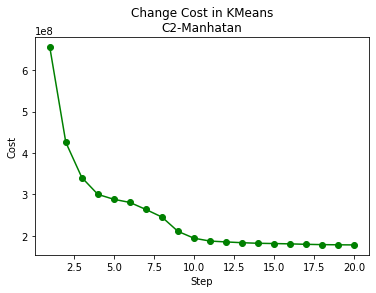

In [ ]:
for distance_metric_name in ["Euclidean", "Manhatan"]:
  for center, center_name in [(c1_pandas, "C1"), (c2_pandas, "C2")]:
    print(f"Distance Metric = {distance_metric_name} | Center Name = {center_name}")

    kmeans = SparkKMeans(dataset=dataset_pandas, center=center,
                         description=f"{center_name}-{distance_metric_name}",
                         distance_metric_name=distance_metric_name)

    kmeans_output = kmeans.run(number_steps=20)

    kmeans.report()    